Import the main libraries for this project

In [86]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler

Load the datasets to analize them separately

In [87]:
# Let's make a preliminary analysis to the datasets
races_df = pd.read_csv("./dataset/races.csv")
cyclist_df = pd.read_csv("./dataset/cyclists.csv")

**Ciclist analysis**
The key for cyclist table is column **_url** that is the name of the cyclist, while in races table the column **cyclist** is a foreign key

In [88]:
def check_key(df, column_name):
    # Check if there are no NaN values and if all values are unique
    return df[column_name].notna().all() and df[column_name].is_unique


def check_in(df1, df2, col1, col2):
    return df1[col1].isin(df2[col2]).all()


print(
    check_key(cyclist_df, "_url")
)  # This column is a key for clyclist dataset
print(
    check_in(races_df, cyclist_df, "cyclist", "_url")
)  # These columns can be used for join

True
True


Some columns have missing values in the cyclist table. For birth_year and nationality we can try to fix them, while we cannot fix weight and height columns since they are NaN for half of the table.

In [89]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


Only cyclist **scott-davies** has missing nationality. We can fix its nationality and birth_year by looking on the web.

In [90]:
# Only one cyclist has nan nationality.
print(
    cyclist_df.loc[cyclist_df.nationality[cyclist_df.nationality.isna()].index]
)


def fix_cyclist(df):
    mask = df["nationality"].isna()
    cyclists = set(df.loc[mask, "_url"])
    for c in cyclists:
        mask = df["_url"] == c
        df.loc[mask, "nationality"] = "Britain"
        df.loc[mask, "birth_year"] = 1995


# Fix using Wikipedia
fix_cyclist(cyclist_df)
print(
    cyclist_df.loc[
        cyclist_df.nationality[cyclist_df._url == "scott-davies"].index
    ]
)

           _url           name  birth_year  weight  height nationality
9  scott-davies  Scott  Davies         NaN     NaN     NaN         NaN
           _url           name  birth_year  weight  height nationality
9  scott-davies  Scott  Davies      1995.0     NaN     NaN     Britain


These cyclist instead have missing birth_year, they are few we can try to fix them.

In [91]:
cyclist_df.loc[cyclist_df.birth_year[cyclist_df.birth_year.isna()].index]

,_url,name,birth_year,weight,height,nationality
601,vladimir-malakov,Vladimir Malakov,NaN,NaN,NaN,Russia
894,antonio-zanini,Antonio Zanini,NaN,NaN,NaN,Italy
2408,filippo-simonetti,Filippo Simonetti,NaN,NaN,NaN,Italy
2515,carlos-garcia,Carlos García,NaN,NaN,NaN,Spain
2536,alexandr-osipov,Alexandr Osipov,NaN,NaN,NaN,Russia
3046,nicolai-kosyakov,Nicolai Kosyakov,NaN,NaN,NaN,Russia
3551,nevens-guy,Guy Nevens,NaN,NaN,NaN,Belgium
4142,oscar-pumar,Oscar Pumar,NaN,NaN,NaN,Venezuela
4384,javier-luquin,Javier Luquin,NaN,NaN,NaN,Spain
4756,thierry-lauder,Thierry Lauder,NaN,NaN,NaN,France


**Races analysis**
Some columns have missing values in races table (**points**, **uci_points**, **climb_total**, **profile**, **average_temperature**, **cyclist_age**, **cycilist_team**).

We can try to fix columns **points**, **cyclist_age** since there are few missing values.
We can drop the column **average_temperature** since there are too many missing values.
We can try to analyze the distribution of **climb_total** over **profile** to try to esitimate and fix the columns.
We can assume that missing values if **cyclist_team** implies 'No team'

In [92]:
races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

There is some noise in the date we can remove the hours, minutes and seconds of start of the races

In [93]:
# Let's remove the noise from dates of races
races_df["date"] = pd.to_datetime(races_df["date"])
races_df["date"] = races_df["date"].dt.normalize()


print(races_df["date"].unique())

<DatetimeArray>
['1978-07-05 00:00:00', '2016-09-03 00:00:00', '2019-07-28 00:00:00',
 '1999-06-17 00:00:00', '2022-07-10 00:00:00', '2017-09-09 00:00:00',
 '1978-07-14 00:00:00', '2018-03-25 00:00:00', '1981-09-05 00:00:00',
 '1994-03-13 00:00:00',
 ...
 '2017-07-29 00:00:00', '2014-05-20 00:00:00', '1982-07-25 00:00:00',
 '2016-07-24 00:00:00', '2010-07-11 00:00:00', '2017-05-07 00:00:00',
 '2000-04-10 00:00:00', '1976-03-09 00:00:00', '2016-03-27 00:00:00',
 '2010-05-08 00:00:00']
Length: 4708, dtype: datetime64[ns]


We can try to check if **points** column is mutually eclusive with **uci_points** column. They aren't

In [94]:
# Points and UCI_Points are not mutually exclusive columns
def are_xor_columns(df, col1, col2):
    mask = df[col1].isna() ^ df[col2].isna()
    res = df.loc[mask, "cyclist"].tolist()
    return len(res) == len(df)


print(are_xor_columns(races_df, "points", "uci_points"))

False


**is_cobbled** and **is_gravel** are all false (we can drop them).
**is_tarmac** is sometimes true and false. It's ok but when it's false also the other columns are false (Noise!!). 

In [95]:
# Some columns are all False
print(races_df.is_cobbled.unique())
print(races_df.is_gravel.unique())
print(races_df.is_tarmac.unique())

[False]
[False]
[ True False]


The delta column have some negative values and also the delta is 0 for many positions different from 0 (Very noisy column!!) (sorted in other notebook)

In [96]:
# A column has inconsistent values. (Negative delta)
print(sorted(races_df.delta.unique())[:100])
# Replace negative values with nan
races_df["delta"] = races_df["delta"].mask(races_df["delta"] < 0, np.nan)

[np.float64(-6906.0), np.float64(-5562.0), np.float64(-2937.0), np.float64(-2638.0), np.float64(-2635.0), np.float64(-2574.0), np.float64(-2567.0), np.float64(-2564.0), np.float64(-2560.0), np.float64(-2550.0), np.float64(-2546.0), np.float64(-2545.0), np.float64(-2542.0), np.float64(-2541.0), np.float64(-2514.0), np.float64(-2513.0), np.float64(-2510.0), np.float64(-2509.0), np.float64(-2505.0), np.float64(-2504.0), np.float64(-2500.0), np.float64(-2487.0), np.float64(-2486.0), np.float64(-2485.0), np.float64(-2482.0), np.float64(-2481.0), np.float64(-2479.0), np.float64(-2477.0), np.float64(-2475.0), np.float64(-2473.0), np.float64(-2469.0), np.float64(-2457.0), np.float64(-2448.0), np.float64(-2446.0), np.float64(-2444.0), np.float64(-2440.0), np.float64(-2438.0), np.float64(-2437.0), np.float64(-2434.0), np.float64(-2432.0), np.float64(-2430.0), np.float64(-2428.0), np.float64(-2425.0), np.float64(-2424.0), np.float64(-2419.0), np.float64(-2416.0), np.float64(-2413.0), np.float64(-

First position in a race is 0. We can check it looking on the web. (sorted in other notebook)

In [97]:
# First position in a race is 0. Delta is always 0 for position 0 and different from 0 for position. Checked using Internet
delta0 = ((races_df["position"] == 0) & (races_df["delta"] == 0)).sum()
delta1 = ((races_df["position"] == 1) & (races_df["delta"] == 0)).sum()
print(delta0)
print(delta1)

# Much Much noise in delta column. All positions have some 0 deltas
positions = sorted(races_df.loc[races_df["delta"].isna(), "position"].unique())
print(positions)
positions = sorted(races_df.loc[races_df["delta"] == 0, "position"].unique())
print(positions)

5281
2738
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71), np.i

Some races have missing profiles. Try to fix looking to the climb_total distribution

In [98]:
# Profile is numerical (difficulty of trace) missing for some races
print(races_df.profile.unique())

[ 1.  5. nan  3.  2.  4.]


The startlist are integers representing how strong the lineup is. They are sparse.

In [99]:
races_df.startlist_quality.unique()[:100]

array([1241,  821, 1699,  804, 1551,  899,  659,  388,  900,  541,  830,
        789,  602,  817, 1400, 1161, 1040,  896,  791,  819,  670,  225,
        520, 1057,  809,  828,  722,  747,  714,  815,  376,  621,  760,
        798,  933, 1994, 1437, 1362,  884, 1150,  971,  881, 1112, 1175,
        891,  878,  400,  936,  692,  727, 1002,  928, 1196, 1489,  687,
        585,  835,  673, 1328,  885,  502,  861,  982,  923, 1036, 1690,
        925,  989, 1109, 1084,  803,  792,  548,  668, 1713, 1520, 1959,
        883,  859, 2047, 1024,  533, 1269,  751, 1202,  570, 1703, 1416,
        251, 1158, 1139,  657, 1048,  521, 1034, 1099,  880, 1029,  627,
        340])

In some races, riders appear two times with different positions. This is wrong and, as we cannot infer which of these positions is the real one, we remove both of them

In [100]:
# remove duplicates with different position
races_df.drop_duplicates(
    subset=races_df.columns.difference(["position"]), inplace=True, keep=False
)

chech if length has unnecessary noise and can be turned into integer

In [101]:
# unralistic to measure length below centimeters
trunc = lambda x: round(x, 2)
races_df.length = races_df["length"].apply(trunc)

print(
    all(x.is_integer() for x in races_df.length.dropna())
)  # true iff all values are integers

# convert length column to integer
races_df.length = races_df.length.astype(int)
# races_df.info()

True


creating stage column for convenience

In [102]:
# _url formatted as race/year/stage

races_df["stage"] = races_df["_url"].str.split("/").str[-1]
races_df.stage.unique()

array(['stage-6', 'stage-14', 'stage-21', 'prologue', 'stage-9',
       'stage-20', 'stage-7', 'stage-2b', 'stage-8b', 'stage-1',
       'stage-2', 'result', 'stage-4', 'stage-5', 'stage-3', 'stage-19',
       'stage-8', 'stage-5b', 'stage-11', 'stage-18', 'stage-15',
       'stage-13', 'stage-12', 'stage-10', 'stage-1a', 'stage-17',
       'stage-16', 'stage-1b', 'stage-12b', 'stage-7a', 'stage-24',
       'stage-3a', 'stage-6a', 'stage-7b', 'stage-5a', 'stage-22',
       'stage-6b', 'stage-4b', 'stage-2a', 'stage-10a', 'stage-15b',
       'stage-4a', 'stage-10b', 'stage-9b', 'stage-8a', 'stage-3b',
       'stage-9a', 'stage-15a', 'stage-12a', 'stage-16b', 'stage-25',
       'stage-23', 'stage-16a', 'stage-18b', 'stage-18a', 'stage-0'],
      dtype=object)

Solve the fact points are missing, for vuelta found online, for tour looked at value of year before and after (always the same)

In [103]:
no_points_races = races_df.loc[races_df.points.isna(), "_url"].unique()
print(no_points_races)
points_dict = {
    "vuelta-a-espana/1994/stage-5": 20,
    "tour-de-france/1986/stage-19": 100,
    "tour-de-france/1988/prologue": 100,
    "tour-de-france/2019/stage-19": 100,
}
for race in no_points_races:
    races_df.loc[races_df._url == race,'points'] = points_dict[race]
    print(races_df.loc[races_df._url == race,'points'])

races_df.points = races_df.points.astype(int)

['vuelta-a-espana/1994/stage-5' 'tour-de-france/1986/stage-19'
 'tour-de-france/1988/prologue' 'tour-de-france/2019/stage-19']
156755    20.0
156756    20.0
156757    20.0
156758    20.0
156759    20.0
          ... 
156915    20.0
156916    20.0
156917    20.0
156918    20.0
156919    20.0
Name: points, Length: 165, dtype: float64
461300    100.0
461301    100.0
461302    100.0
461303    100.0
461304    100.0
          ...  
461430    100.0
461431    100.0
461432    100.0
461433    100.0
461434    100.0
Name: points, Length: 135, dtype: float64
517517    100.0
517518    100.0
517519    100.0
517520    100.0
517521    100.0
517522    100.0
517523    100.0
517524    100.0
517525    100.0
517526    100.0
517527    100.0
517528    100.0
517529    100.0
517530    100.0
517531    100.0
517532    100.0
517533    100.0
517534    100.0
517535    100.0
517536    100.0
517537    100.0
517538    100.0
Name: points, dtype: float64
561313    100.0
561314    100.0
561315    100.0
561316    100.0
561

See if there are uci points missing (they start from a certain date, do first we get that, then wee see in date afterwards if there are missing)
**Problem**: still lot of dates, maintain but if not useful drop

In [113]:
# get oldest _url with uci points not null
oldest_date = races_df.loc[races_df.uci_points.notna(), "date"].min()
uci_races = races_df.loc[races_df.date >= oldest_date]
uci_races.info()

2001-06-27 00:00:00
<class 'pandas.core.frame.DataFrame'>
Index: 412042 entries, 106 to 589864
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   _url                 412042 non-null  object        
 1   name                 412042 non-null  object        
 2   points               412042 non-null  int64         
 3   uci_points           251086 non-null  float64       
 4   length               412042 non-null  int64         
 5   climb_total          337318 non-null  float64       
 6   profile              357719 non-null  float64       
 7   startlist_quality    412042 non-null  int64         
 8   average_temperature  29933 non-null   float64       
 9   date                 412042 non-null  datetime64[ns]
 10  position             412042 non-null  int64         
 11  cyclist              412042 non-null  object        
 12  cyclist_age          411989 non-null  float64       
 1

try to solve cyclist teams null values

(5092,)

## Data understanding

Now we can build the joined table and analyze the data together

In [105]:
class DataUnderstander:
    def __init__(self, races_csv, cyclist_csv, merged_csv=None):
        # So keep ref to all datasets and make one joined
        self.races_df = races_csv
        self.cyclist_df = cyclist_csv

        if merged_csv == None:
            self.df = pd.merge(
                self.races_df,
                self.cyclist_df,
                left_on="cyclist",
                right_on="_url",
                how="inner",
            )
        else:
            self.df = pd.read_csv(merged_csv, parse_dates=["date"])

        # Delete useless columns for the joined table
        self.delete_column("_url_y")
        self.delete_column("name_y")

        # Delete columns that are all false
        self.delete_column("is_cobbled")
        self.delete_column("is_gravel")

        # Rename to understand better
        self.df.rename(
            columns={
                "name_x": "location",
                "_url_x": "url",
            },
            inplace=True,
        )

        # dm.export_csv() # Save the merged version of dataset

    def delete_column(self, col):
        self.df.drop(columns=[col], inplace=True)

    def fill_nan(self, column, value):
        self.df[column].fillna(value, inplace=True)

    def export_csv(self):
        return self.df.to_csv("./dataset/dataset.csv")

    def correlate(self):
        correlations = {
            correlation_type: self.df.corr(
                numeric_only=True, method=correlation_type
            )
            for correlation_type in ("kendall", "pearson", "spearman")
        }

        for i, k in enumerate(correlations.keys()):
            correlations[k].loc[:, "correlation_type"] = k

        # Loop through each correlation type and create separate plots
        for corr_type, corr_matrix in correlations.items():
            corr_matrix = corr_matrix.drop(columns=["correlation_type"])

            # Create a new figure for each correlation type
            plt.figure(figsize=(12, 12))

            # Plot the heatmap
            sns.heatmap(
                corr_matrix,
                annot=True,
                cmap="coolwarm",
                fmt=".2f",
                linewidths=0.5,
            )

            # Set the title for the plot
            plt.title(f"{corr_type.capitalize()} Correlation")

            # Display the plot
            plt.show()

    def normalize(self):
        numeric_columns = [
            "points",
            "length",
            "climb_total",
            "profile",
            "startlist_quality",
            "cyclist_age",
            "delta",
            "birth_year",
            "weight",
            "height",
        ]
        scaler = StandardScaler()  # Si prova con la zscore ora eh
        self.df[numeric_columns] = scaler.fit_transform(
            self.df[numeric_columns]
        )

In [106]:
dm = DataUnderstander(races_df, cyclist_df)  # Initialize the datasets

In [107]:
dm.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589771 entries, 0 to 589770
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   url                  589771 non-null  object        
 1   location             589771 non-null  object        
 2   points               589771 non-null  int64         
 3   uci_points           251086 non-null  float64       
 4   length               589771 non-null  int64         
 5   climb_total          442772 non-null  float64       
 6   profile              441651 non-null  float64       
 7   startlist_quality    589771 non-null  int64         
 8   average_temperature  29933 non-null   float64       
 9   date                 589771 non-null  datetime64[ns]
 10  position             589771 non-null  int64         
 11  cyclist              589771 non-null  object        
 12  cyclist_age          589658 non-null  float64       
 13  is_tarmac     

In [108]:
# Try to fix missing birth_year or age using the other column. Nothing they always nan at the same time

ages = dm.df.groupby("cyclist")["cyclist_age"].unique()

ages = ages.apply(lambda x: np.isnan(x).all())
# names for which is true
ages = ages[ages == True].index

for idx, name in enumerate(ages):
    print(idx, name)
    print(cyclist_df.loc[cyclist_df._url == name].birth_year)

0 alexandr-osipov
2536   NaN
Name: birth_year, dtype: float64
1 antonio-zanini
894   NaN
Name: birth_year, dtype: float64
2 batik-odriozola
6080   NaN
Name: birth_year, dtype: float64
3 carlos-garcia
2515   NaN
Name: birth_year, dtype: float64
4 filippo-simonetti
2408   NaN
Name: birth_year, dtype: float64
5 javier-luquin
4384   NaN
Name: birth_year, dtype: float64
6 nevens-guy
3551   NaN
Name: birth_year, dtype: float64
7 nicolai-kosyakov
3046   NaN
Name: birth_year, dtype: float64
8 oscar-pumar
4142   NaN
Name: birth_year, dtype: float64
9 scott-davies
9    1995.0
Name: birth_year, dtype: float64
10 sergei-jermachenko
6072   NaN
Name: birth_year, dtype: float64
11 thierry-lauder
4756   NaN
Name: birth_year, dtype: float64
12 vladimir-malakov
601   NaN
Name: birth_year, dtype: float64


Now we can build the build the correlation matrix to try to understand which columns are correlated.

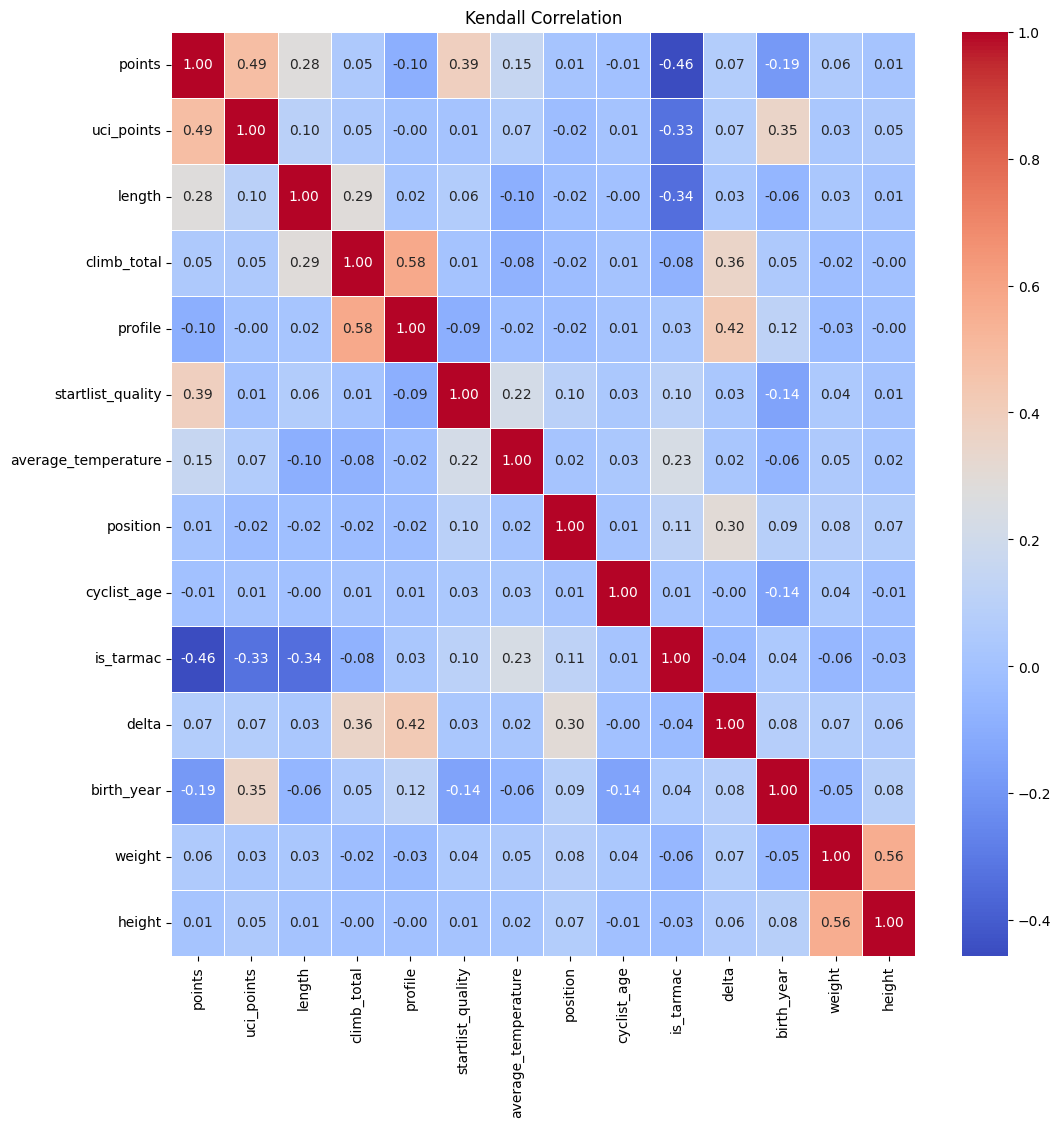

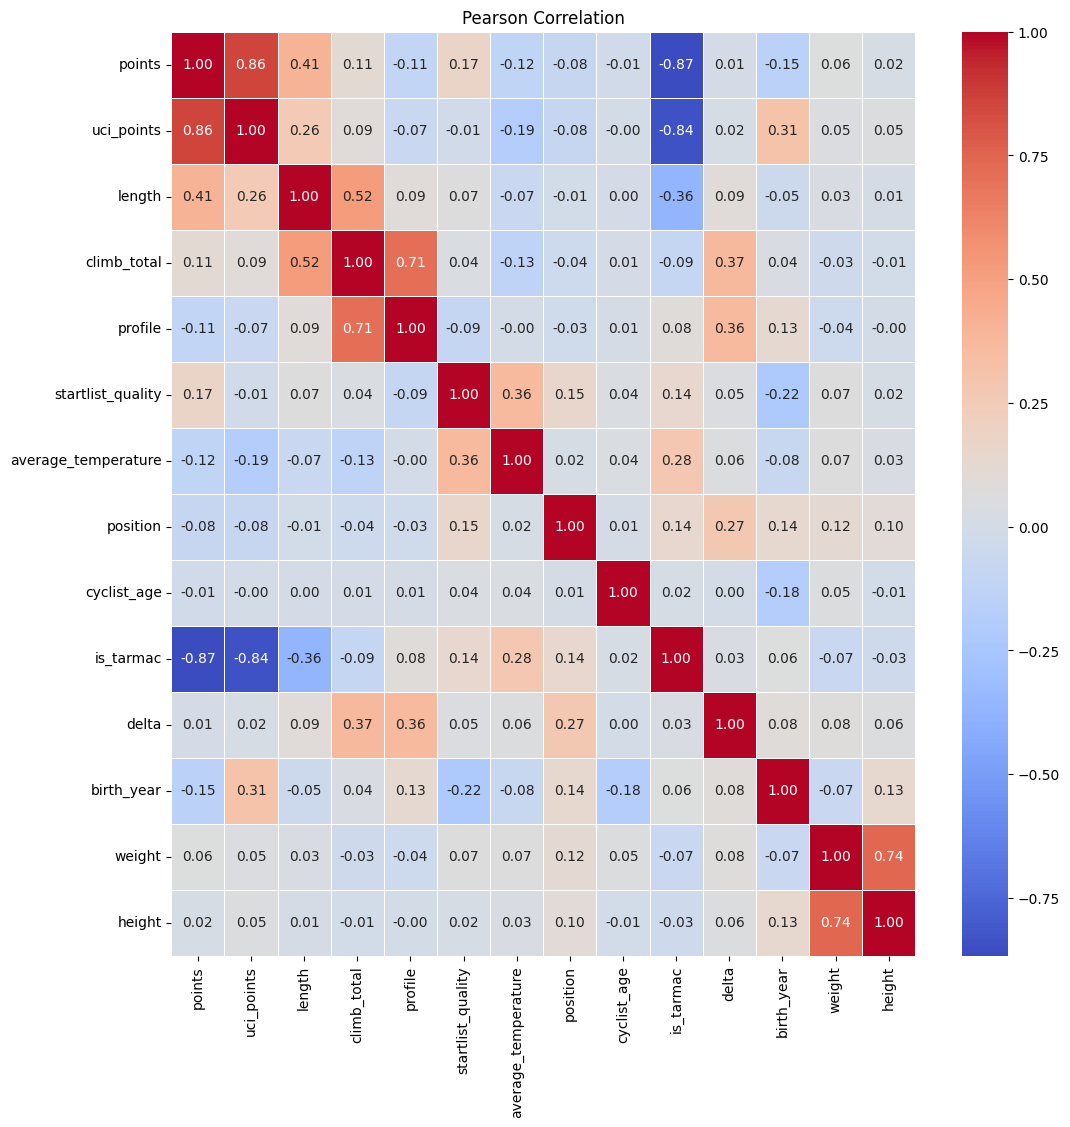

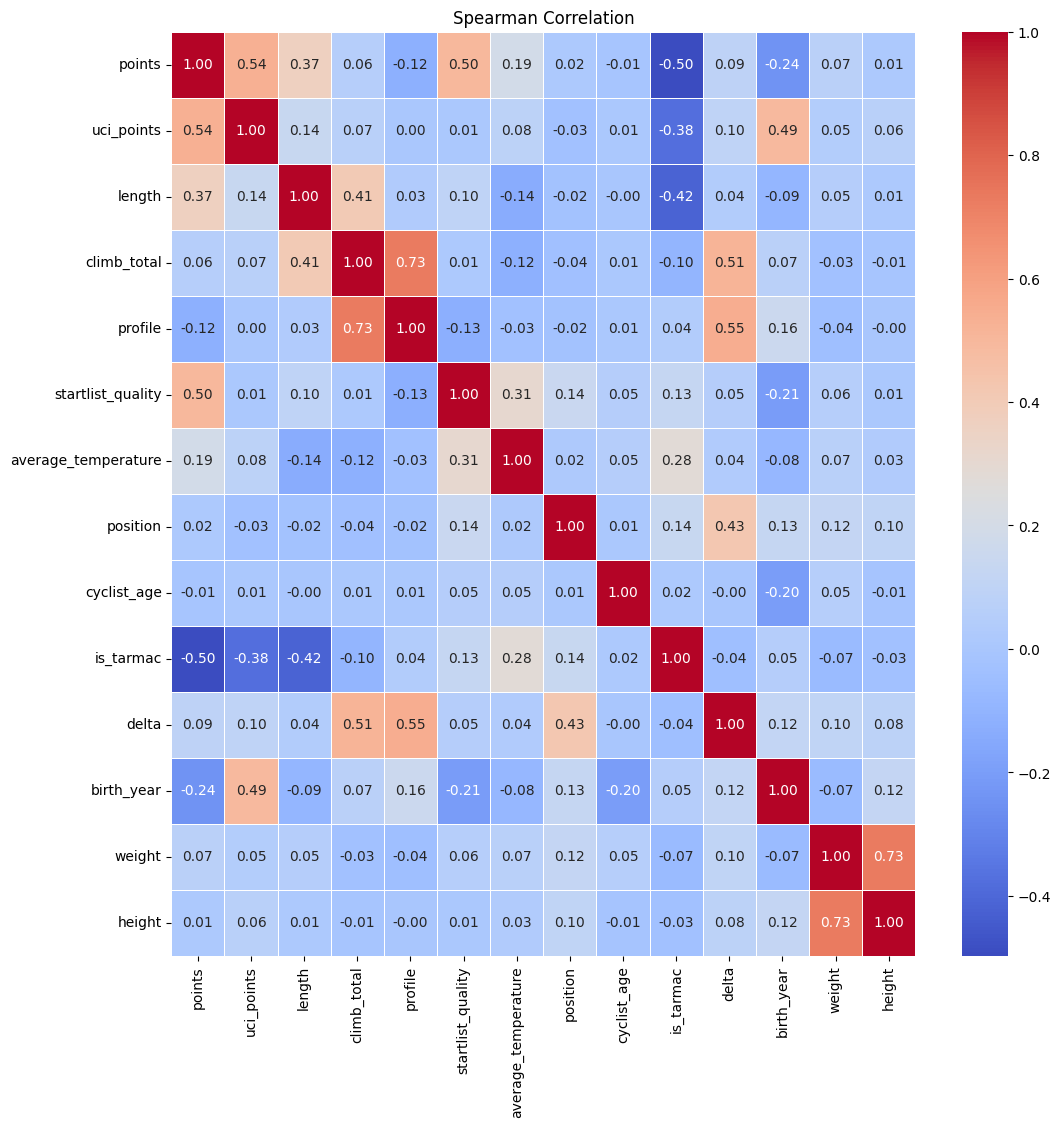

In [109]:
dm.normalize()
dm.correlate()

In all the 3 plots we can observe:
- We can observe that the columns **climb_total** and **profile** are highly correlated, so we can use them to fix the missing values.
- We can observe that weight and height are highly correlated but we can expect this because it's naturally true.
- We can observe that **points** and **uci_points** are highly correlated.
- We can observe that **profile** and **delta** are correlated.
- We can observe that **climb_total** and **delta** are correlated.
- We can observe that **startlist_quality** and **points** are correlated.
- We can observe that **length** and **points** are correlated.
- We can observe that **birth_year** and **uci_points** are correlated.
Note: Normalizing the data does not affect the correlation matrix.